In [46]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [47]:
train = pd.read_csv('C:\Users\Steven\Documents\Git\Machine-Learning\HousePrices\\train.csv')
test = pd.read_csv('C:\Users\Steven\Documents\Git\Machine-Learning\HousePrices\\test.csv')

In [48]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [50]:
train_clean = train

del train_clean['Alley']
del train_clean['FireplaceQu']
del train_clean['PoolQC']
del train_clean['Fence']
del train_clean['MiscFeature']

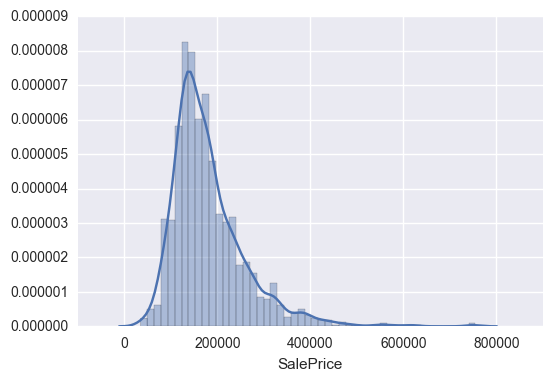

In [51]:
sns.distplot(train_clean['SalePrice'])

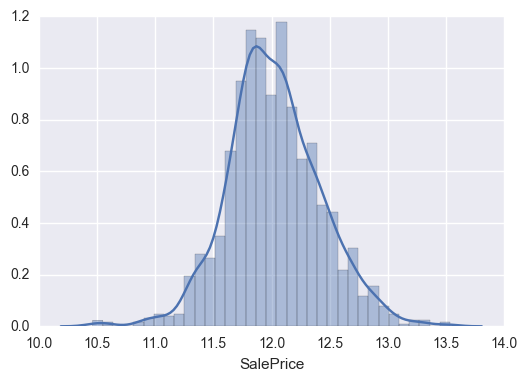

In [52]:
train_clean['SalePrice'] = np.log(train_clean['SalePrice'])
sns.distplot(train_clean['SalePrice'])

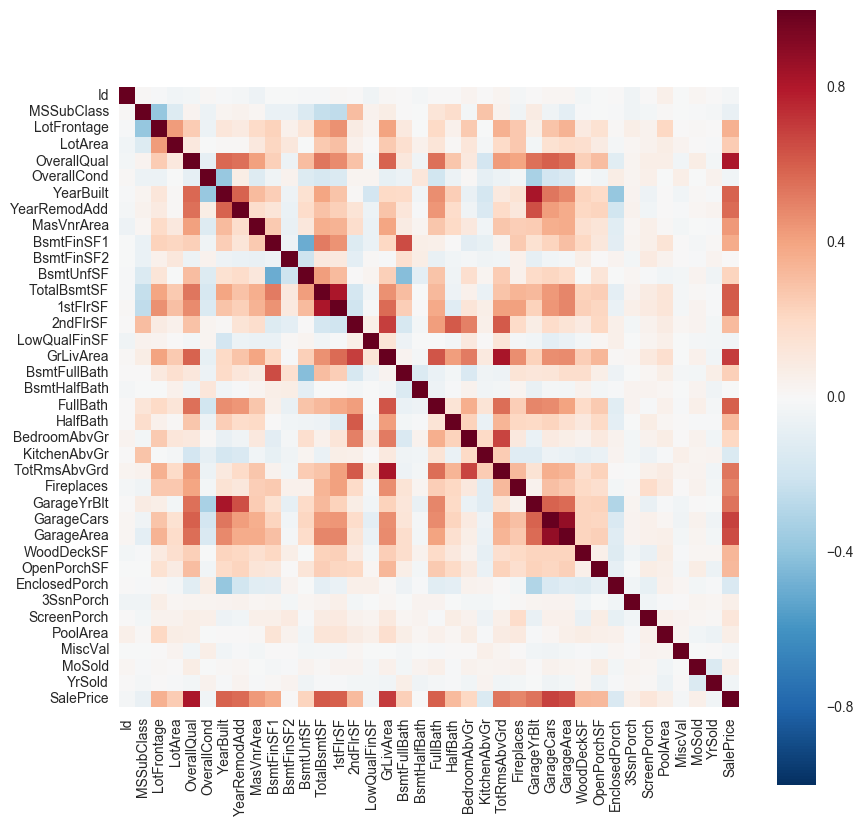

In [53]:
corr = train_clean.select_dtypes(include = ['float64', 'int64']).corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corr, square = True)

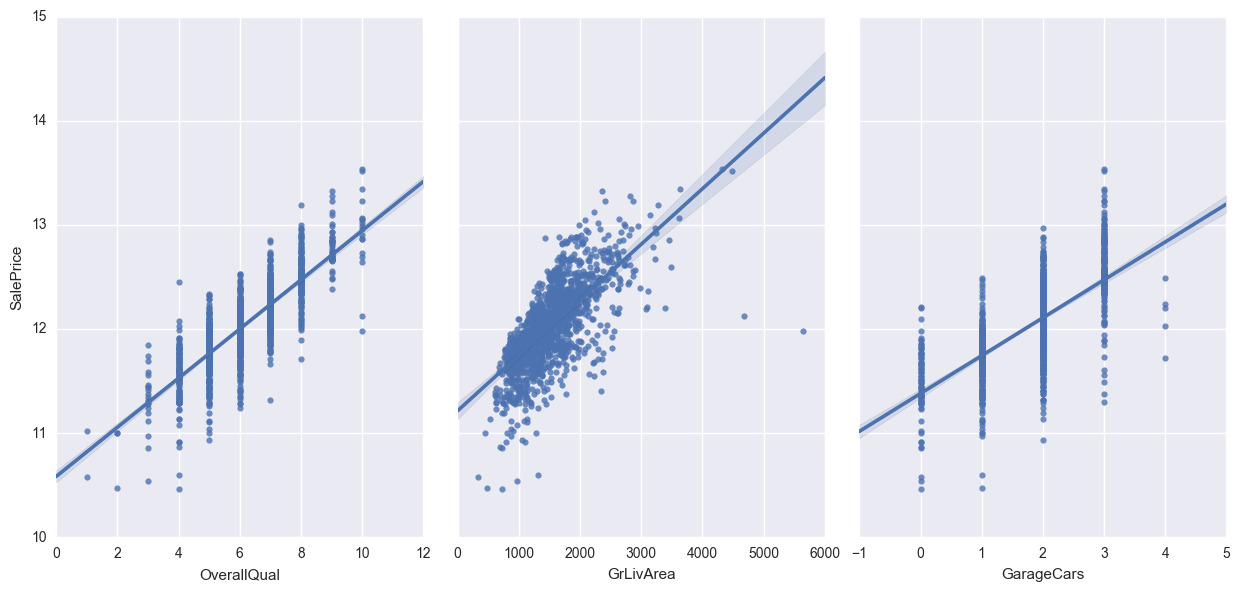

In [54]:
sns.pairplot(train_clean, x_vars = ['OverallQual', 'GrLivArea', 'GarageCars'], y_vars = 'SalePrice', size = 6, aspect = 0.7, kind = 'reg')

In [55]:
df = train_clean[['OverallQual', 'GrLivArea', 'GarageCars', 'SalePrice']]
X, y = df.drop('SalePrice', axis = 1), df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [56]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
predictions = linreg.predict(X_test)
print np.sqrt(metrics.mean_squared_error(y_test, predictions))

0.179194785207


In [57]:
df2 = train_clean[[
    'OverallQual',
    'GrLivArea',
    'GarageCars',
    'GarageArea',
    'TotalBsmtSF',
    '1stFlrSF',
    'FullBath',
    'TotRmsAbvGrd',
    'YearBuilt',
    'YearRemodAdd',
    'SalePrice'
]]
X_new, y_new = df2.drop('SalePrice', axis = 1), df2['SalePrice']
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, random_state = 1)

In [58]:
linreg.fit(X_train_new, y_train_new)
predictions_new = linreg.predict(X_test_new)
print np.sqrt(metrics.mean_squared_error(y_test_new, predictions_new))

0.157845148169


In [59]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

In [60]:
test['GarageCars'] = test['GarageCars'].fillna(test['GarageCars'].median())
test['GarageArea'] = test['GarageArea'].fillna(test['GarageArea'].median())
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].median())
test['YearRemodAdd'] = test['YearRemodAdd'].fillna(test['YearRemodAdd'].median())

In [61]:
Id = test['Id']
test_clean = test
del test_clean['Alley']
del test_clean['FireplaceQu']
del test_clean['PoolQC']
del test_clean['Fence']
del test_clean['MiscFeature']

In [62]:
test_final = test_clean[[
    'OverallQual',
    'GrLivArea',
    'GarageCars',
    'GarageArea',
    'TotalBsmtSF',
    '1stFlrSF',
    'FullBath',
    'TotRmsAbvGrd',
    'YearBuilt',
    'YearRemodAdd'
]]

In [65]:
Id = pd.DataFrame(Id, columns = ['Id'])
result = linreg.predict(test_final)
result = pd.DataFrame(abs(result), columns = ['SalePrice'])
result = pd.concat([Id, pd.DataFrame(result)], axis = 1, join_axes = [Id.index])
result['SalePrice'] = np.exp(result['SalePrice'])
result.head()

,Id,SalePrice
0,1461,111886.872634
1,1462,141597.665743
2,1463,162589.668549
3,1464,180204.428718
4,1465,207253.513754


In [66]:
result.to_csv('submission.csv', sep = ',', index = False)